# ALMA Data Example

Trey V. Wenger (c) December 2024

Here we test `bayes_cn_hfs` on some real ALMA data and demonstrate a general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+7.gdcf859e.dirty


## Load the data

12CN 1021
13CN 1021


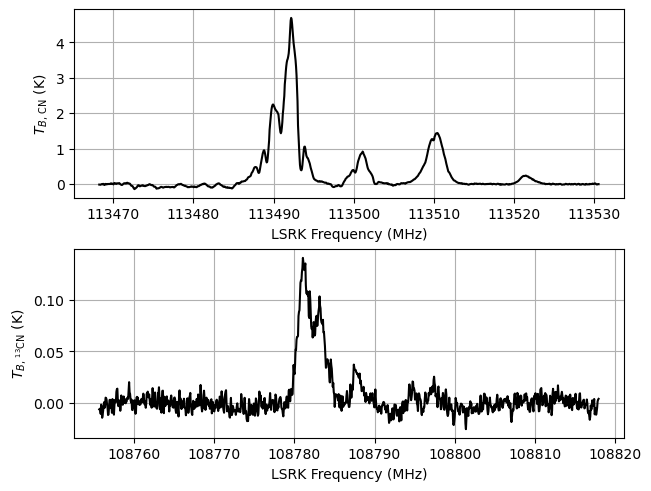

In [2]:
from bayes_spec import SpecData

data_12CN = np.genfromtxt("data_CN.tsv")
data_13CN = np.genfromtxt("data_13CN.tsv")

# estimate noise
noise_12CN = 1.4826 * np.median(np.abs(data_12CN[:, 0] - np.median(data_12CN[:, 0])))
noise_13CN = 1.4826 * np.median(np.abs(data_13CN[:, 0] - np.median(data_13CN[:, 0])))

obs_12CN = SpecData(
    1000.0 * data_12CN[:, 0],
    data_12CN[:, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
obs_13CN = SpecData(
    1000.0 * data_13CN[:, 0],
    data_13CN[:, 1],
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
data = {"12CN": obs_12CN, "13CN": obs_13CN}

for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# subset of 12CN data
data_12CN = {
    label: data[label]
    for label in data.keys() if "12CN" in label
}

# Plot the data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(data["12CN"].spectral, data["12CN"].brightness, 'k-')
axes[1].plot(data["13CN"].spectral, data["13CN"].brightness, 'k-')
axes[0].set_xlabel(data["12CN"].xlabel)
axes[1].set_xlabel(data["13CN"].xlabel)
axes[0].set_ylabel(data["12CN"].ylabel)
_ = axes[1].set_ylabel(data["13CN"].ylabel)

## Inspecting the CN data

Can we constrain the excitation temperature and optical depth? How about the hyperfine anomalies? It seems like there are two cloud components, so let's explore the data with that assumption for now. We assume make the weak LTE assumption such that the kinetic temperature is equal to the mean cloud excitation temperature. We are otherwise unable to constrain the kinetic temperature because non-thermal broadening is important and we have poor spectral resolution.

In [31]:
from bayes_cn_hfs.cn_model import CNModel
from bayes_cn_hfs import supplement_mol_data

mol_data_12CN, mol_weight_12CN = supplement_mol_data("CN")

n_clouds = 4
baseline_degree = 0
model = CNModel(
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=1.0, # Main beam efficiency
    Feff=1.0, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [13.75, 0.5], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = None, # ignored because kinetic temperature is fixed
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 5.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 5.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [1.0, 0.5], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN, LTE_precision, baseline_12CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


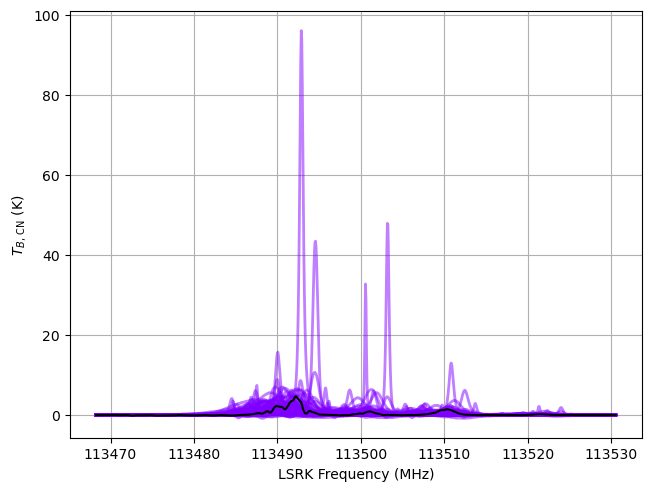

In [32]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [ ]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

In [26]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_freeRVs + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
velocity[0],-2.783,0.012,-2.805,-2.760,0.000,0.000,960.0,936.0,NaN
velocity[1],-4.537,0.008,-4.551,-4.520,0.000,0.000,1022.0,914.0,NaN
velocity[2],-1.496,0.010,-1.517,-1.479,0.000,0.000,1034.0,874.0,NaN
velocity[3],-3.455,0.004,-3.463,-3.448,0.000,0.000,1012.0,907.0,NaN
fwhm_thermal[0],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal[1],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal[2],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal[3],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_nonthermal[0],0.101,0.114,0.002,0.290,0.004,0.003,1030.0,857.0,NaN
fwhm_nonthermal[1],2.780,0.022,2.741,2.824,0.001,0.000,996.0,844.0,NaN


Sampling: [12CN]


Output()

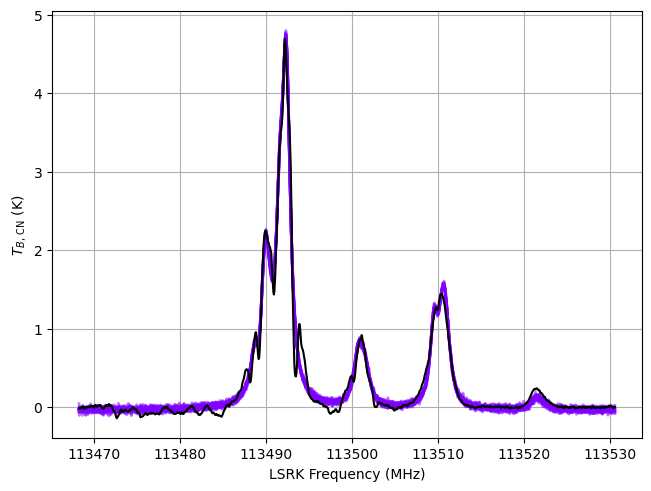

In [27]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Number of cloud components
We first explore the CN data, which have greater signal-to-noise, in order to constrain the optical depths, excitation temperatures, and number of cloud components. We assume non-thermal broadening is important, so we fix the kinetic temperature. We otherwise assume a non-LTE model with hyperfine anomalies. Therefore the assumption of a fixed kinetic temperature only biases our inference of the thermal line width.

In [10]:
from bayes_spec import Optimize

max_n_clouds = 10
baseline_degree = 0
opt = Optimize(
    CNModel,
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=1.0, # Main beam efficiency
    Feff=1.0, # Forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_log10_N = [13.5, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = [0.75, 0.25], # ignored because kinetic temperature is fixed
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.75, 0.25], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 100.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Sampling: [12CN, LTE_precision, baseline_12CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


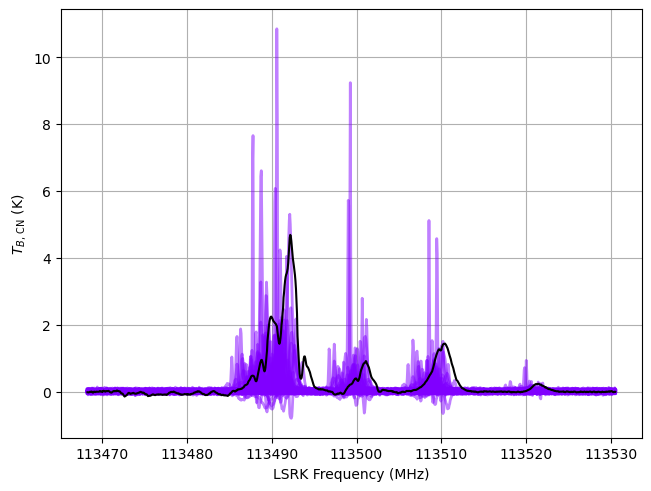

In [11]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = opt.models[1].sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(opt.models[1].data, prior.prior_predictive)

Approximate all models with variational inference.

In [12]:
start = time.time()
fit_kwargs = {
    "n": 100_000,
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.01,
}
opt.fit_all(**fit_kwargs)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.837e+05
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 8000
Interrupted at 7,999 [7%]: Average Loss = 1.1927e+05


Output()

n_cloud = 1 BIC = 5.585e+04

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 1.2651e+05


Output()

n_cloud = 2 BIC = 3.525e+04

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 9500
Interrupted at 9,499 [9%]: Average Loss = 92,886


Output()

n_cloud = 3 BIC = 1.901e+04

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 7600
Interrupted at 7,599 [7%]: Average Loss = 1.1042e+05


Output()

n_cloud = 4 BIC = 1.554e+04

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 9700
Interrupted at 9,699 [9%]: Average Loss = 81,099


Output()

n_cloud = 5 BIC = 7.626e+03

Approximating n_cloud = 6 posterior...


Output()

Convergence achieved at 8700
Interrupted at 8,699 [8%]: Average Loss = 2.347e+05


Output()

n_cloud = 6 BIC = 1.489e+03

Approximating n_cloud = 7 posterior...


Output()

Convergence achieved at 9700
Interrupted at 9,699 [9%]: Average Loss = 94,783


Output()

n_cloud = 7 BIC = 1.602e+03

Approximating n_cloud = 8 posterior...


Output()

Convergence achieved at 8700
Interrupted at 8,699 [8%]: Average Loss = 5.9108e+07


Output()

n_cloud = 8 BIC = 2.237e+03

Approximating n_cloud = 9 posterior...


Output()

Convergence achieved at 10700
Interrupted at 10,699 [10%]: Average Loss = 5.3082e+05


Output()

n_cloud = 9 BIC = -6.844e+02

Approximating n_cloud = 10 posterior...


Output()

Convergence achieved at 12300
Interrupted at 12,299 [12%]: Average Loss = 1.1134e+05


Output()

n_cloud = 10 BIC = -9.211e+02

Runtime: 11.94 minutes


[ 9.83688523e+05  5.58504114e+04  3.52455252e+04  1.90117547e+04
  1.55444625e+04  7.62600791e+03  1.48856440e+03  1.60188133e+03
  2.23749306e+03 -6.84420421e+02 -9.21149999e+02]


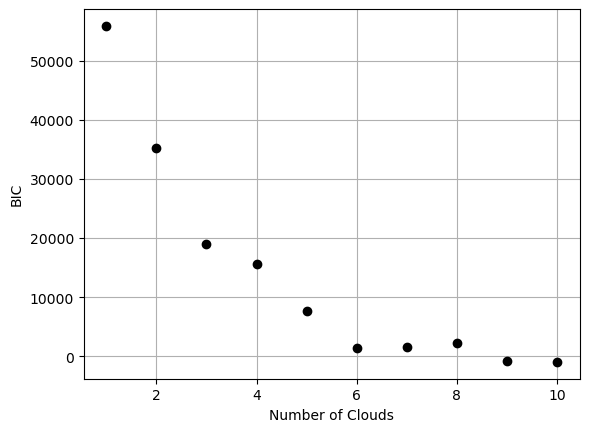

In [13]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
print(bics_vi)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko')
plt.xlabel("Number of Clouds")
_ = plt.ylabel("BIC")

In [14]:
start = time.time()
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.01,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 100_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.837e+05
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8000
Interrupted at 7,999 [7%]: Average Loss = 1.1927e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 2471 seconds.


Adding log-likelihood to trace


Output()

There were 67 divergences in converged chains.
GMM found 2 unique solutions
Solution 0: chains [0, 2, 5]
Solution 1: chains [1, 3, 6]
6 of 8 chains appear converged.
n_cloud = 1 solution = 0 BIC = 5.064e+04
n_cloud = 1 solution = 1 BIC = 5.064e+04

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 1.2651e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 5239 seconds.


Adding log-likelihood to trace


Output()

There were 955 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 9500
Interrupted at 9,499 [9%]: Average Loss = 92,886
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 6908 seconds.


Adding log-likelihood to trace


Output()

There were 865 divergences in converged chains.
GMM converged to unique solution
4 of 8 chains appear converged.
n_cloud = 3 solution = 0 BIC = 4.783e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 7600
Interrupted at 7,599 [7%]: Average Loss = 1.1042e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 8150 seconds.


Adding log-likelihood to trace


Output()

There were 2893 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 9700
Interrupted at 9,699 [9%]: Average Loss = 81,099
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 9819 seconds.


Adding log-likelihood to trace


Output()

There were 1061 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Sampling n_cloud = 6 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8700
Interrupted at 8,699 [8%]: Average Loss = 2.347e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 11203 seconds.


Adding log-likelihood to trace


Output()

There were 28 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Sampling n_cloud = 7 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 9700
Interrupted at 9,699 [9%]: Average Loss = 94,783
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 12707 seconds.


Adding log-likelihood to trace


Output()

There were 129 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Sampling n_cloud = 8 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8700
Interrupted at 8,699 [8%]: Average Loss = 5.9108e+07
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 14238 seconds.


Adding log-likelihood to trace


Output()

There were 63 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Sampling n_cloud = 9 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 10700
Interrupted at 10,699 [10%]: Average Loss = 5.3082e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_N_norm, log10_Tex_ul_norm, LTE_precision, weights]


Output()

Sampling 8 chains for 440 tune and 0 draw iterations (3_520 + 0 draws total) took 2399 seconds.


Adding log-likelihood to trace


KeyError: 'posterior'

There is not a unique solution. Must supply solution.
No solutions. Try solve()
No solutions. Try solve()
No solutions. Try solve()
No solutions. Try solve()
No solutions. Try solve()
No solutions. Try solve()
No solutions. Try solve()
No solutions. Try solve()
[983688.52343729             inf             inf   4782.92092377
             inf             inf             inf             inf
             inf             inf             inf]


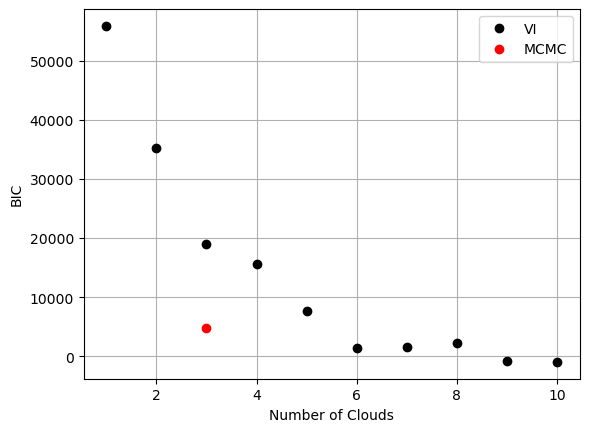

In [15]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_mcmc = np.array([null_bic] + [model.bic() for model in opt.models.values()])
print(bics_mcmc)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko', label="VI")
plt.plot(n_clouds[1:], bics_mcmc[1:], 'ro', label="MCMC")
plt.xlabel("Number of Clouds")
plt.ylabel("BIC")
_ = plt.legend()

In [16]:
# model = opt.best_model
model = opt.models[3]
print(model.n_clouds)
model.solve()

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
]
pm.summary(model.trace.solution_0, var_names=var_names + ["LTE_precision"] + model.hyper_freeRVs + model.hyper_deterministics + model.baseline_freeRVs)

3
GMM converged to unique solution
4 of 8 chains appear converged.


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
velocity[0],-4.271,0.005,-4.281,-4.261,0.000,0.000,752.0,1553.0,1.00
velocity[1],-2.203,0.006,-2.214,-2.193,0.000,0.000,695.0,1584.0,1.01
velocity[2],-3.093,0.017,-3.123,-3.061,0.001,0.000,801.0,1509.0,1.00
fwhm_thermal[0],0.236,0.000,0.236,0.236,0.000,0.000,4000.0,4000.0,NaN
fwhm_thermal[1],0.236,0.000,0.236,0.236,0.000,0.000,4000.0,4000.0,NaN
fwhm_thermal[2],0.236,0.000,0.236,0.236,0.000,0.000,4000.0,4000.0,NaN
fwhm_nonthermal[0],1.982,0.009,1.964,1.998,0.000,0.000,781.0,1232.0,1.01
fwhm_nonthermal[1],1.500,0.010,1.482,1.518,0.000,0.000,920.0,1499.0,1.00
fwhm_nonthermal[2],6.976,0.039,6.904,7.048,0.001,0.001,800.0,1252.0,1.00
fwhm[0],1.996,0.009,1.979,2.012,0.000,0.000,781.0,1232.0,1.01


Sampling: [12CN]


Output()

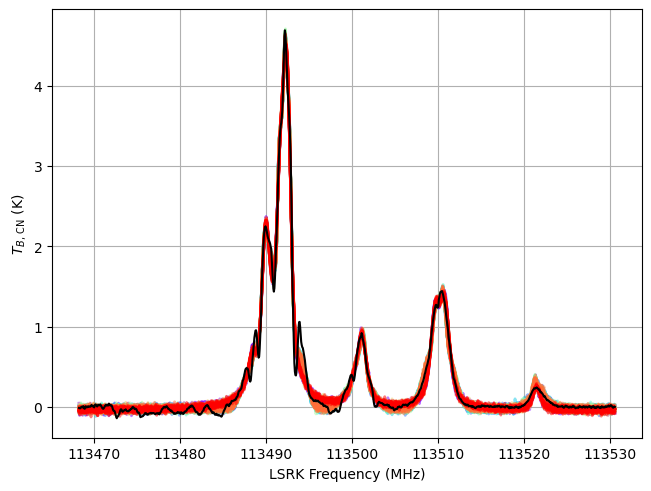

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

In [ ]:
print("solutions:", model.solutions)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state_l", "state_u"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_deterministics + model.baseline_freeRVs)

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)